## Evaluation

Making evaluation more streamlined

### Setup and Parameters

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from crnn import CNN_BiGRU_Classifier
import math
from tqdm.notebook import tqdm
from training_data import data_preproc, load_pre_data
from sklearn.model_selection import train_test_split
from greedy_decoder import GreedyCTCDecoder, beam_search_decoder
from utils import get_actual_transcript, get_model_savepath, get_motifs_identified
import datetime
import pandas as pd
import numpy as np

# Parameters
output_classes = 19

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"Running on {device}")

labels_int = np.arange(output_classes).tolist()
labels = [f"{i}" for i in labels_int] # Tokens to be fed into greedy decoder
greedy_decoder = GreedyCTCDecoder(labels=labels)

# Model Parameters
input_size = 1 
hidden_size = 256
num_layers = 4
output_size = output_classes 
dropout_rate = 0.2
ctc_loss = nn.CTCLoss(zero_infinity=True)
n_classes = output_classes
step_sequence = 100
window_overlap = 50
length_per_sample = 150

# Loading the dataset
dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\datasets\empirical\sampled_test_dataset_v4_spacers.pkl"

dataset_df = pd.read_pickle(dataset_path)

Running on cuda


### Separating into cycles

In [2]:
def get_cycle_dfs(dataset_df, sample=False, samples=100, ont=True):
    """Seperate dataframe by unique cycles """
    
    if ont:
        onts = dataset_df['ONT_Barcode'].unique()
        
    hws = dataset_df['HW_Address'].unique()
    cycle_dfs = []

    if ont:
        for ont in onts:
            for hw in hws:
                filtered_df = dataset_df[(dataset_df['ONT_Barcode'] == ont) & (dataset_df['HW_Address'] == hw)]
                cycle_dfs.append(filtered_df)
    else:
        for hw in hws:
            filtered_df = dataset_df[(dataset_df['HW_Address'] == hw)]
            cycle_dfs.append(filtered_df)

    if sample:
        sampled_cycle_dfs = [df.sample(n=samples) for df in cycle_dfs]
        return sampled_cycle_dfs

    return cycle_dfs

In [35]:
sampled_cycle_dfs = get_cycle_dfs(
    dataset_df=dataset_df,
    sample=True, 
    samples=10)

# 192 cycles in the v1 unseen dataset

### Loading the Model/s


In [7]:
def load_model(model_path, device):
    """
    Loading model purely for inference
    Will need to lead optimizer to fine tune
    """
    # Model Definition
    model = CNN_BiGRU_Classifier(input_size, hidden_size, num_layers, output_size, dropout_rate)

    if device == torch.device('cpu'):
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(model_path)

    model.load_state_dict(checkpoint['model_state_dict'])

    model = model.to(device)
    return model

In [11]:
import os

models_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\models\empirical"

v1_path = os.path.join(models_path, 'model_10_11_24.pth')
alpha_model_path = os.path.join(models_path, 'v6')


model_paths = {
'alpha_0' : '0.pth',
'alpha_1e-3' : '1e-3.pth',
'alpha_1e-4' : '1e-4.pth',
'alpha_1e-5' : '1e-5.pth',
}

model_paths = {k: os.path.join(alpha_model_path, v) for k, v in model_paths.items()}
model_paths['v1'] = v1_path


model_labels = list(model_paths.keys())
model_paths = list(model_paths.values())

In [20]:
models = [load_model(model_path, device) for model_path in model_paths]

### Data Splitting Function and cycle from transcripts

In [13]:

from sklearn.preprocessing import normalize

def split_norm(X, normalize_data=True):
        
    step_sequence = 100
    window_overlap = 50
    length_per_sample = 150
    # So we split and norm it
    sequences_dataset = []
    for i in X:

        if normalize_data:
            j = normalize([i]).flatten()

        sequence_length = len(j)
            
        n_samples = math.ceil(sequence_length//step_sequence) # Since we send the last one even if it is small as can be

        ptr = 0
        counter = 0
        sequences = torch.zeros([n_samples, 1, length_per_sample])
        while ptr <= sequence_length:
            
            try:
                if ptr + length_per_sample > sequence_length:
                    break
                else:
                    sequence_chop = j[ptr:ptr+length_per_sample]
                    
                sequence_chop = torch.tensor(sequence_chop, dtype=torch.float32).view(1, len(sequence_chop))
                sequences[counter] = sequence_chop
            except IndexError:
                print("Index problem")
        
            ptr += step_sequence
            counter+=1
        
        sequences_dataset.append(sequences)
         
    return sequences_dataset

In [14]:
def sort_transcript(transcript):

    cycles = [[] for i in range(8)]

    split_transcript = transcript.split()
    split_transcript = [int(i) for i in split_transcript  if i != '']

    for i in range(len(split_transcript)):
        
        found_motif = split_transcript[i]
        
        # If we have a payload motif
        if found_motif < 9:

            # finding the spacers - only for payload cycles
            if i > 0:

                # Checking for Back Spacer
                if split_transcript[i-1] > 10:
                    cycle_number = split_transcript[i-1] - 11
                    cycles[cycle_number].append(split_transcript[i])

                # Checking for Forward Spacer
                elif i < len(split_transcript) - 1:
                    if split_transcript[i+1] > 10:
                        cycle_number = split_transcript[i+1] - 11
                        cycles[cycle_number].append(split_transcript[i])

            else:
                if i < len(split_transcript) - 1:
                    # Checking for Forward Spacer
                    if split_transcript[i+1] > 10:
                        cycle_number = split_transcript[i+1] - 11
                        cycles[cycle_number].append(split_transcript[i])   

    return cycles

In [15]:
def get_motifs_identified_cycle_level(pred, target):

    motifs_identified = 0
    for pred_cycle, target_cycle in zip(pred, target):
        motifs_identifed_arr = [motif for motif in pred_cycle if motif in target_cycle]
        motifs_identified += len([motif for motif in pred_cycle if motif in target_cycle])

    return motifs_identified / 32


## Model Evaluation

In [16]:
def test_model(model, X_test, y_test):
    # Test Loop
    model.eval()
    test_loss = 0.0
    distances_arr = []
    motifs_identifed_arr = []
    greedy_transcripts = []
    actual_transcripts = []
    with torch.no_grad():
        for i in range(len(X_test)):

            test_sequence, target_sequence = torch.tensor(X_test[i]).to(device), torch.tensor(y_test[i]).to(device)

            model_output_timestep = model(test_sequence) # Getting model output

            input_lengths = torch.tensor(X_test[i].shape[0])
            target_lengths = torch.tensor(len(target_sequence))

            loss = ctc_loss(model_output_timestep, target_sequence, input_lengths, target_lengths)
            test_loss += loss.item()

            greedy_result = greedy_decoder(model_output_timestep)
            greedy_transcript = greedy_result
            
            actual_transcript = get_actual_transcript(target_sequence)
            greedy_transcripts.append(greedy_transcript)
            actual_transcripts.append(actual_transcript)

    return greedy_transcripts, actual_transcripts



In [17]:


def run_evaluation(sampled_cycle_dfs, models, model_labels):

    motifs_identified_caller_cycles= {k: [] for k in model_labels}
    motifs_identified_search_cycles = []

    for test_cycle in tqdm(sampled_cycle_dfs):

        X_test = split_norm(test_cycle['squiggle'].to_numpy())
        y_test = test_cycle['Spacer_Sequence'].to_list()

        for model, model_label in (zip(models, model_labels)):
        
            greedy_transcripts, actual_transcripts = test_model(
                model=model,
                X_test=X_test,
                y_test=y_test
            )

            payloads = test_cycle['Payload'].to_list()

            motifs_identified_caller = []
            motifs_identified_search = []
            
            for caller, search, payload in zip(greedy_transcripts, actual_transcripts, payloads):
                motifs_identified_caller.append(get_motifs_identified_cycle_level(sort_transcript(caller), payload))

                motifs_identified_search.append(get_motifs_identified_cycle_level(sort_transcript(search), payload))

            motifs_identified_caller_cycles[model_label].append(motifs_identified_caller)
        
        motifs_identified_search_cycles.append(motifs_identified_search)

    return motifs_identified_caller_cycles, motifs_identified_search_cycles

In [36]:
motifs_identified_caller_cycles, motifs_identified_search_cycles = run_evaluation(sampled_cycle_dfs, models, model_labels)

  0%|          | 0/192 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\to

In [32]:
motifs_identified_caller_cycles

{'alpha_0': [[0.0],
  [0.125],
  [0.03125],
  [0.0625],
  [0.03125],
  [0.03125],
  [0.125],
  [0.0],
  [0.1875],
  [0.0625],
  [0.03125],
  [0.03125],
  [0.03125],
  [0.0],
  [0.0625],
  [0.03125],
  [0.0],
  [0.0625],
  [0.0625],
  [0.0],
  [0.03125],
  [0.125],
  [0.03125],
  [0.0625],
  [0.0625],
  [0.0625],
  [0.125],
  [0.09375],
  [0.125],
  [0.03125],
  [0.15625],
  [0.125],
  [0.0625],
  [0.1875],
  [0.0],
  [0.03125],
  [0.09375],
  [0.09375],
  [0.09375],
  [0.125],
  [0.21875],
  [0.0],
  [0.03125],
  [0.0625],
  [0.125],
  [0.09375],
  [0.125],
  [0.09375],
  [0.0],
  [0.21875],
  [0.0],
  [0.09375],
  [0.125],
  [0.1875],
  [0.1875],
  [0.0625],
  [0.125],
  [0.0],
  [0.03125],
  [0.0625],
  [0.21875],
  [0.0],
  [0.09375],
  [0.03125],
  [0.0],
  [0.0],
  [0.125],
  [0.0],
  [0.125],
  [0.09375],
  [0.0],
  [0.09375],
  [0.03125],
  [0.0],
  [0.0],
  [0.09375],
  [0.09375],
  [0.0],
  [0.03125],
  [0.0625],
  [0.0],
  [0.0625],
  [0.0],
  [0.125],
  [0.0625],
  [0.0625],

In [37]:
mean_acc = {label:float(np.mean(cycle_accs)) for (cycle_accs, label) in zip(motifs_identified_caller_cycles.values(), model_labels)}

In [38]:
mean_acc

{'alpha_0': 0.07516276041666667,
 'alpha_1e-3': 0.069580078125,
 'alpha_1e-4': 0.048665364583333336,
 'alpha_1e-5': 0.06502278645833333,
 'v1': 0.09568684895833333}

In [41]:
np.mean(motifs_identified_search_cycles)

np.float64(0.07350260416666667)

Seems like 0.001 does better than the 0 (could just be noise but let's double check for other data)

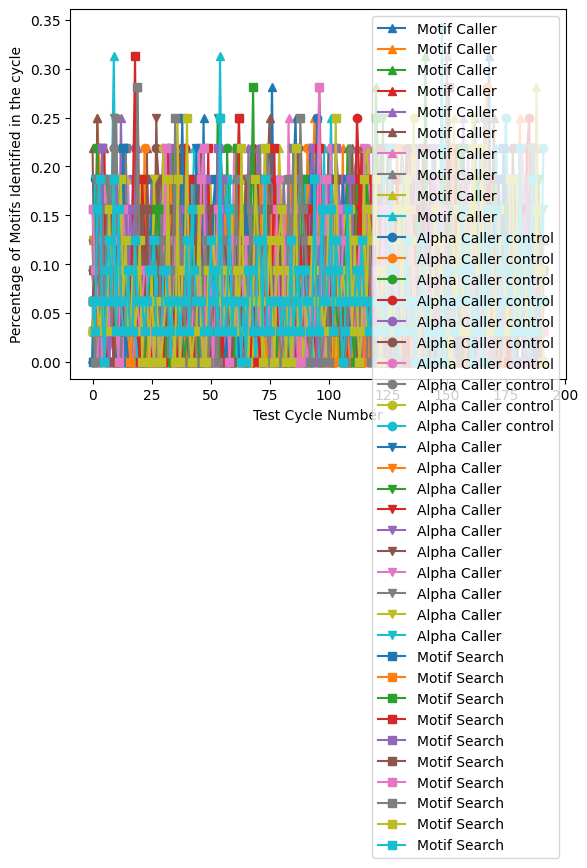

In [40]:
import matplotlib.pyplot as plt


plt.plot(motifs_identified_caller_cycles['v1'], label='Motif Caller', marker='^')
plt.plot(motifs_identified_caller_cycles['alpha_0'], label='Alpha Caller control', marker='o')
plt.plot(motifs_identified_caller_cycles['alpha_1e-5'], label='Alpha Caller', marker='v')
plt.plot(motifs_identified_search_cycles, label='Motif Search', marker='s')
plt.xlabel('Test Cycle Number')
plt.ylabel('Percentage of Motifs Identified in the cycle')
plt.legend()
plt.show()


### Running evaluation for larger sample (100)
To see if results change - since its pretty consistent across cycles - can do lower amount of cycles with more samples each to investigate
also might be interesting to see max performance

In [ ]:
sampled_cycle_dfs = get_cycle_dfs(
        dataset_df=dataset_df,
        sample=True, 
        samples=100)

models = [load_model(
    model_path=model_path, device=device) for model_path in model_paths]

motifs_identified_caller_cycles, motifs_identified_search_cycles = run_evaluation(sampled_cycle_dfs=sampled_cycle_dfs[:50],
               models=models,
               model_labels=model_labels)

  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\to

In [108]:
mean_acc = {label:float(np.mean([np.mean(i) for i in cycle_accs])) for (cycle_accs, label) in zip(motifs_identified_caller_cycles.values(), model_labels)}
print(mean_acc)
print(np.mean(motifs_identified_search_cycles))

{'v1': 0.09246875, 'alpha_0': 0.0831875, 'alpha_0.001': 0.08978124999999999, 'alpha_0.05': 0.077875, 'alpha_0.1': 0.08221875000000001}
0.073375


In [113]:
maxes = {label:[np.max(i) for i in cycle_accs] for (cycle_accs, label) in zip(motifs_identified_caller_cycles.values(), model_labels)}
print(mean_acc)
print(np.max(motifs_identified_search_cycles))

{'v1': 0.3125, 'alpha_0': 0.28125, 'alpha_0.001': 0.28125, 'alpha_0.05': 0.3125, 'alpha_0.1': 0.28125}
0.28125


In [114]:
maxes_search = [np.max(i) for i in motifs_identified_search_cycles]

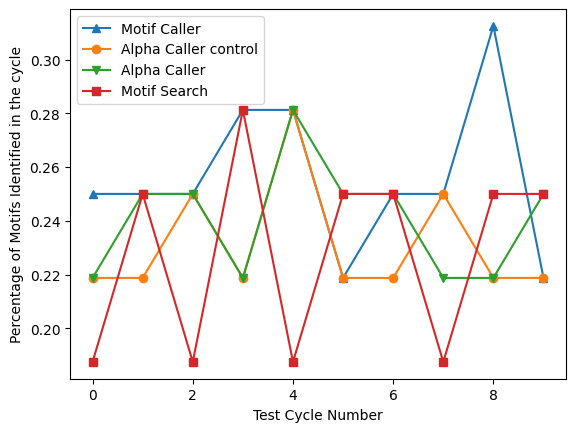

In [115]:
plt.plot(maxes['v1'], label='Motif Caller', marker='^')
plt.plot(maxes['alpha_0'], label='Alpha Caller control', marker='o')
plt.plot(maxes['alpha_0.001'], label='Alpha Caller', marker='v')
plt.plot(maxes_search, label='Motif Search', marker='s')
plt.xlabel('Test Cycle Number')
plt.ylabel('Percentage of Motifs Identified in the cycle')
plt.legend()
plt.show()


In [102]:
# Look at max performance and std



### V2 Sequencing run dataset

In [82]:
dataset_v2_path = r'C:\Users\Parv\Doc\HelixWorks\Basecalling\code\datasets\empirical\empirical_train_dataset_2_v1.pkl'

dataset_v2 = pd.read_pickle(dataset_v2_path)

In [83]:
dataset_v2 = dataset_v2.rename(columns={'payloads': 'Payload'})

In [93]:
sampled_cycle_dfs = get_cycle_dfs(
        dataset_df=dataset_v2,
        sample=True,
        samples=100,
        ont=False)


In [94]:
motifs_identified_caller_cycles, motifs_identified_search_cycles = run_evaluation(sampled_cycle_dfs=sampled_cycle_dfs,
               models=models,
               model_labels=model_labels)

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\to

In [95]:
mean_acc = {label:float(np.mean(cycle_accs)) for (cycle_accs, label) in zip(motifs_identified_caller_cycles.values(), model_labels)}
print(mean_acc)
print(np.mean(motifs_identified_search_cycles))

{'v1': 0.072609375,
 'alpha_0': 0.06124999999999999,
 'alpha_0.001': 0.0690625,
 'alpha_0.05': 0.05254687500000001,
 'alpha_0.1': 0.057218750000000006}

np.float64(0.182703125)

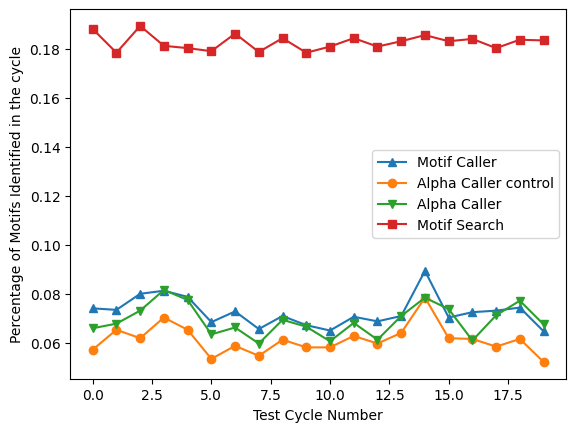

In [97]:

plt.plot(motifs_identified_caller_cycles['v1'], label='Motif Caller', marker='^')
plt.plot(motifs_identified_caller_cycles['alpha_0'], label='Alpha Caller control', marker='o')
plt.plot(motifs_identified_caller_cycles['alpha_0.001'], label='Alpha Caller', marker='v')
plt.plot(motifs_identified_search_cycles, label='Motif Search', marker='s')
plt.xlabel('Test Cycle Number')
plt.ylabel('Percentage of Motifs Identified in the cycle')
plt.legend()
plt.show()
